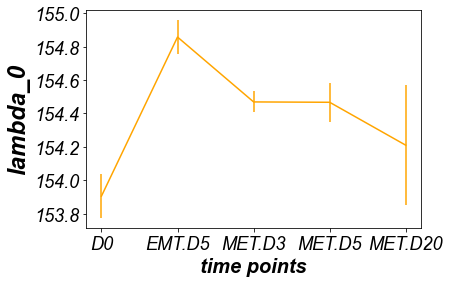

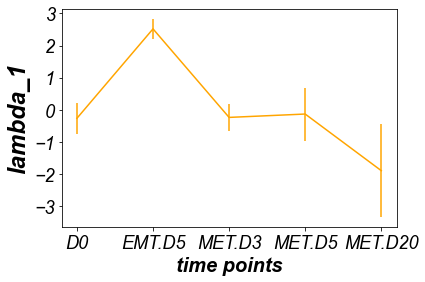

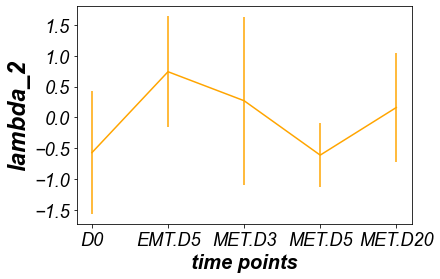

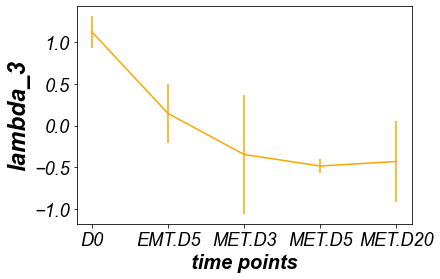

'cols = take_cols_mean(expression_mat_tfs)\nY = make_matrix(cols)\nw, lambda_arrays, G_array = surprisal_analysis(Y)\nrep = reproduce_data(w,lambda_arrays,G_array,num_order_reproduce,time_point)\nenergy = free_energy(lambda_arrays,G_array,gene_num,phenotype)\n\nconsistency_check(G_array)\n\nprint(energy)'

In [1]:
#!/usr/bin/env python
# coding: utf-8

# import required packages

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# function to read the entire matrix and output a dictionary
def read_full_dictionary(filename):
    time_series = []
    expression_dict = {}
    with open(filename) as file:
        for line in file:
            if "Probe_ID" in line:
                time_series = (re.split('\t|\n',line)[2:-1])
            else:
                temp = re.split('\t|\n',line)[2:-1]
                gene_name = re.split('\t|\n',line)[1]
                if gene_name in expression_dict:
                    print(gene_name," already present!")
                else:
                    temp = list(map(float, temp))
                    expression_dict[gene_name] = np.array(temp)
    return expression_dict, time_series

# function to create only a smaller dictionary with specified genes
def create_a_reduced_dictionary(expression_dict,gene_list,separator = " /// "):
    reduced_expression_dict = {}
    for i in expression_dict:
        a = i.split(separator)
        for j in a:
            if j in gene_list:
                if j in reduced_expression_dict:
                    print(j," already present (reduced dictionary creation) Not adding again !")
                    continue
                reduced_expression_dict[j] = expression_dict[i]
    return reduced_expression_dict

# convert a dictionary to a matrix
def make_matrix_from_dict(expression_dict):
    expression_mat = []
    gene_list = []
    for i in expression_dict:
        expression_mat.append(expression_dict[i])
        gene_list.append(i)
    expression_mat = np.array(expression_mat)
    return expression_mat,gene_list
    
# read a specific list of genes (fucntionally relevant stuff like tfs)
def read_list_of_specific_genes(path_to_specific_genes):
    gene_list = []
    with open(path_to_specific_genes) as f:
        for line in f:
            a = line[:-1]
            gene_list.append(a)
    return gene_list
    
# Use this function to return columns that are required
def get_cols(expression_mat,rep_array):
    tup = []
    for i in rep_array:
        tup.append(expression_mat[:,int(i)])
    return tuple(tup)

# set up paths to specific files
filename = "SNAI2_gene.txt"
path_to_replicates = "./replicates.txt"
path_to_tfs = "list_of_human_transcription_factors.txt"

# Read file and create a data structure to store it
def read_file_to_matrix(filename):
    time_series = []
    expression_mat = []
    with open(filename) as file:
        for line in file:
            if "Probe_ID" in line:
                time_series = (re.split('\t|\n',line)[2:-1])
                #print(time_series)
            else:
                temp = re.split('\t|\n',line)[2:-1]
                temp = list(map(float, temp))
                expression_mat.append(temp)
    expression_mat = np.array(expression_mat) 
    return expression_mat, time_series

# Make matrix for surprisal analysis
def make_matrix(cols):
    for i in range(len(cols)):
        temp = cols[i][:,np.newaxis]
        if i == 0:
            Y = temp
        else:
            Y = np.hstack((Y,temp))
    return Y

# Function for surprisal analysis
def surprisal_analysis(Y):
    Y = np.log(Y)
    Yt = Y.transpose()
    
    a = np.matmul(Yt,Y)
    evalues, evectors = np.linalg.eig(a)
    w = np.sqrt(evalues)
    
    # find eigenvectors
    
    lambda_arrays = []
    
    for i,j in enumerate(w):
        lambda_arrays.append(j*evectors[:,i])
    
    # find constrains
    
    G_array = []
    
    for i,j in enumerate(w):
        temp = np.array(lambda_arrays[i])
        G_array.append(np.dot(Y,temp)/(j**2))
    
    return w, lambda_arrays, G_array


# Reproduce data
def reproduce_data(w,lambda_arrays,G_array,num_order_reproduce,time_point):
    rep = 0
    for i in range(num_order_reproduce):
        rep += lambda_arrays[i][time_point]*G_array[i]    
    return rep

# Consistency check
def consistency_check(G_array):
    for i in range(len(G_array)):
        print("Consistency Check: ",i,"\t",np.dot(np.transpose(G_array[i]),G_array[i]))

# Calculate free energy
def free_energy(lambda_arrays,G_array,gene_num,phenotype):
    return(lambda_arrays[phenotype]*G_array[phenotype][gene_num])

# Plot graph with error bars
def plot_errorbar_plots(t,data,ylab,xlab):
    mean_array = np.zeros(len(data[0]))
    std_array = np.zeros(len(data[0]))
    for i in data:
        mean_array += np.array(i)/len(data)
    for i,j in enumerate(data[0]):
        x = []
        for k in data:
            x.append(k[i])
        std_array[i] = np.std(x)
    plt.errorbar(t,mean_array,yerr=std_array,c="orange")
    plt.xlabel(xlab,fontname="Arial", fontsize=20, style='italic', fontweight='bold')
    plt.ylabel(ylab,fontname="Arial", fontsize=24, style='italic', fontweight='bold')
    plt.xticks(np.arange(5), ('D0', 'EMT.D5', 'MET.D3', 'MET.D5', 'MET.D20'),fontname="Arial", fontsize = 18, style='italic')
    plt.yticks(fontname="Arial", fontsize =18 , style='italic')
    plt.show()

# Main function
num_order_reproduce = 2
time_point = 2


expression_dict, time_series = read_full_dictionary(filename)
tfs = read_list_of_specific_genes(path_to_tfs)
expression_mat_full,genelistfull = make_matrix_from_dict(expression_dict)
reduced_expression_dict = create_a_reduced_dictionary(expression_dict,tfs)
expression_mat_tfs,genelisttfs = make_matrix_from_dict(reduced_expression_dict)

expression_mat_full = np.power(expression_mat_full,2)
expression_mat_tfs = np.power(expression_mat_tfs,2)

def correct_evectors_sign(arr):
    init = arr[0]
    for i,j in enumerate(arr):
        arr[i] = np.sign(np.dot(np.transpose(init),arr[i])) * arr[i]
    return arr

lamb = {0:[],1:[],2:[],3:[]}
G = {0:[],1:[],2:[],3:[]}
rep_num = 0
with open(path_to_replicates) as f:
    for line in f:
        rep_num+=1
        a = line[:-1].split("\t")
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change matrix here 
        cols = get_cols(expression_mat_tfs,a)
        Y = make_matrix(cols)
        w, lambda_arrays, G_array = surprisal_analysis(Y)
        #consistency_check(G_array)
        lamb[0].append(lambda_arrays[0])
        lamb[1].append(lambda_arrays[1])
        lamb[2].append(lambda_arrays[2])
        lamb[3].append(lambda_arrays[3])
        G[0].append(G_array[0])
        G[1].append(G_array[1])
        G[2].append(G_array[2])
        G[3].append(G_array[3])
        
x = list(dict.fromkeys(time_series)) ## Remove duplicates from time_series
x = list(map(float,x))
        
total_replicates = 3
for phenotype in range(4):
    lamb[phenotype] = correct_evectors_sign(lamb[phenotype])
    G[phenotype] = correct_evectors_sign(G[phenotype])
    #for rep_num in range(total_replicates):
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change name here
        #with open("./replicates/tfs_replicate_"+str(rep_num)+"_phenotype_"+str(phenotype)+".txt","w") as f1:
            #for idx,g in enumerate(G[phenotype][rep_num]):
                # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change gene list here
                #s = str(idx)+"\t"+str(genelisttfs[idx])+"\t"+str(g)
                #free_energy_array = lamb[phenotype][rep_num]*G[phenotype][rep_num][idx]
                #for timept in free_energy_array:
                    #s+="\t"+str(timept)
                #f1.write(s+"\n")
    plot_errorbar_plots(x,correct_evectors_sign(lamb[phenotype]),"lambda_"+str(phenotype),"time points")
    
"""cols = take_cols_mean(expression_mat_tfs)
Y = make_matrix(cols)
w, lambda_arrays, G_array = surprisal_analysis(Y)
rep = reproduce_data(w,lambda_arrays,G_array,num_order_reproduce,time_point)
energy = free_energy(lambda_arrays,G_array,gene_num,phenotype)

consistency_check(G_array)

print(energy)"""

In [2]:
import operator

#storing each sample in a separate dictionary
def create_dictionaries_for_samples(filename,sampleno):
    sample_dict = {}
    with open(filename) as f:
        for line in f:
            if 'Probe_ID' not in line:
                temp1 = re.split('\t|\n',line)[1]
                temp2 = re.split('\t|\n',line)[sampleno+1]
                sample_dict[temp1]=temp2
    return sample_dict
                    
filename = "SNAI2_gene.txt"

def read_pathway_name(path_to_pathway_list,lno):
    with open(path_to_pathway_list) as f:
        for i,line in enumerate(f):
            if i == lno:
                line=line.strip()
                lines=line.split(";")
                return lines[0]

def read_genes_of_pathway(path_to_pathway_list,lno):
    gene_list = []
    with open(path_to_pathway_list) as f:
        for i,line in enumerate(f):
            if i == lno:
                line=line.strip()
                lines=line.split(";")
                a = lines[1:]
                if a != '':
                    gene_list.append(a)
    return gene_list

#sorting each sample dictionary by gene expression values in ascending order,storing ranks of genes in each sample in sort_orders list
sort_orders = []
for i in range(1,16):
    sample_dict = create_dictionaries_for_samples(filename,i)
    sorted_x = sorted(sample_dict.items(), key=lambda x: x[1])
    out_dict = {}
    for idx, (key, _) in enumerate(sorted_x):
        out_dict[key] = idx + 1
    sort_orders.append(out_dict)


In [12]:
import numpy as np
import math 

path_to_pathway_list="Wiki_Pathways.txt"

flatten = lambda t: [item for sublist in t for item in sublist]

N_total = 19852           #total number of genes in each sample

def get_singscore(gene_list_of_pathway,sample_no):     #function to find SingScore of a pathway for a sample
    singscore = 0
    s = 0
    count_n = 0
    for g in gene_list_of_pathway:     #loop for iterating through the genes in the pathway
        if(sort_orders[sample_no].get(g,0) != 0):
            rank = sort_orders[sample_no].get(g,0)
            rank_norm = abs(rank - math.ceil (N_total/2))
            count_n = count_n+1
            s = s + rank_norm
    singscore = s/count_n
    s_min = (math.ceil(count_n/2)+1)/2
    s_max = (N_total-math.ceil(count_n/2)+1)/2
    singscore_norm = (singscore - s_min)/(s_max - s_min)
    return singscore_norm
 
pathway_expression_dict = {}
    
for i in range(0,587):      #loop for iterating through the pathways
    pathway_name = read_pathway_name(path_to_pathway_list,i)
    gene = flatten(read_genes_of_pathway(path_to_pathway_list,i))
    array = np.empty(15,dtype='float')
    for j in range(0,15):   #loop for iterating through the samples for each pathway, 26 scores for each pathway
        array[j] = get_singscore(gene,j)
    pathway_expression_dict[pathway_name]=array

5
5
5
Top upregulated 20 pathways for lambda_0:
['WP_TGIF_DISRUPTION_OF_SHH_SIGNALING', 'WP_SECRETION_OF_HYDROCHLORIC_ACID_IN_PARIETAL_CELLS', 'WP_ENDOCHONDRAL_OSSIFICATION', 'WP_ENDOCHONDRAL_OSSIFICATION_WITH_SKELETAL_DYSPLASIAS', 'WP_DIFFERENTIATION_PATHWAY', 'WP_CATALYTIC_CYCLE_OF_MAMMALIAN_FLAVINCONTAINING_MONOOXYGENASES_FMOS', 'WP_SOMATIC_SEX_DETERMINATION', 'WP_HFE_EFFECT_ON_HEPCIDIN_PRODUCTION', 'WP_ACE_INHIBITOR_PATHWAY', 'WP_PLATELETMEDIATED_INTERACTIONS_WITH_VASCULAR_AND_CIRCULATING_CELLS', 'WP_EDA_SIGNALLING_IN_HAIR_FOLLICLE_DEVELOPMENT', 'WP_SMALL_LIGAND_GPCRS', 'WP_HEMATOPOIETIC_STEM_CELL_DIFFERENTIATION', 'WP_HEDGEHOG_SIGNALING_PATHWAY_NETPATH', 'WP_PATHOGENESIS_OF_SARSCOV2_MEDIATED_BY_NSP9NSP10_COMPLEX', 'WP_BLOOD_CLOTTING_CASCADE', 'WP_COVID19_THROMBOSIS_AND_ANTICOAGULATION', 'WP_THYROXINE_THYROID_HORMONE_PRODUCTION', 'WP_GASTRIC_ACID_PRODUCTION', 'WP_SCFA_AND_SKELETAL_MUSCLE_SUBSTRATE_METABOLISM']
Top downregulated 20 pathways for lambda_0:
['WP_MIR517_RELATIONSHIP_WIT

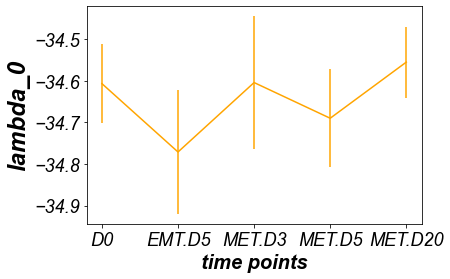

Top upregulated 20 pathways for lambda_1:
['WP_GASTRIC_CANCER_NETWORK_1', 'WP_HOMOLOGOUS_RECOMBINATION', 'WP_MIR5093P_ALTERATION_OF_YAP1ECM_AXIS', 'WP_MACROPHAGE_MARKERS', 'WP_CONTROL_OF_IMMUNE_TOLERANCE_BY_VASOACTIVE_INTESTINAL_PEPTIDE', 'WP_LET7_INHIBITION_OF_ES_CELL_REPROGRAMMING', 'WP_STEROID_BIOSYNTHESIS', 'WP_DUAL_HIJACK_MODEL_OF_VIF_IN_HIV_INFECTION', 'WP_CELLS_AND_MOLECULES_INVOLVED_IN_LOCAL_ACUTE_INFLAMMATORY_RESPONSE', 'WP_HYPERTROPHY_MODEL', 'WP_COVID19_ADVERSE_OUTCOME_PATHWAY', 'WP_TAMOXIFEN_METABOLISM', 'WP_BENZOAPYRENE_METABOLISM', 'WP_DDX1_AS_A_REGULATORY_COMPONENT_OF_THE_DROSHA_MICROPROCESSOR', 'WP_SARSCOV2_AND_ANGIOTENSINCONVERTING_ENZYME_2_RECEPTOR_MOLECULAR_MECHANISMS', 'WP_NUCLEOTIDE_GPCRS', 'WP_COVID19_THROMBOSIS_AND_ANTICOAGULATION', 'WP_THYROXINE_THYROID_HORMONE_PRODUCTION', 'WP_NICOTINE_METABOLISM', 'WP_CATALYTIC_CYCLE_OF_MAMMALIAN_FLAVINCONTAINING_MONOOXYGENASES_FMOS']
Top downregulated 20 pathways for lambda_1:
['WP_SCFA_AND_SKELETAL_MUSCLE_SUBSTRATE_METABOLIS

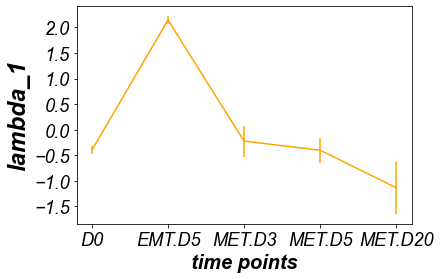

Top upregulated 20 pathways for lambda_2:
['WP_CARDIAC_PROGENITOR_DIFFERENTIATION', 'WP_MIRNA_TARGETS_IN_ECM_AND_MEMBRANE_RECEPTORS', 'WP_INFLAMMATORY_RESPONSE_PATHWAY', 'WP_CELL_DIFFERENTIATION_INDEX_EXPANDED', 'WP_MACROPHAGE_MARKERS', 'WP_AMINO_ACID_METABOLISM_PATHWAY_EXCERPT_HISTIDINE_CATABOLISM_EXTENSION', 'WP_COMPLEMENT_ACTIVATION', 'WP_COMPOSITION_OF_LIPID_PARTICLES', 'WP_CELL_DIFFERENTIATION_INDEX', 'WP_GDNFRET_SIGNALLING_AXIS', 'WP_COVID19_ADVERSE_OUTCOME_PATHWAY', 'WP_SOMITOGENESIS_IN_THE_CONTEXT_OF_SPONDYLOCOSTAL_DYSOSTOSIS', 'WP_NUCLEOTIDE_GPCRS', 'WP_STEROID_BIOSYNTHESIS', 'WP_GPR40_PATHWAY', 'WP_SULINDAC_METABOLIC_PATHWAY', 'WP_GENE_REGULATORY_NETWORK_MODELLING_SOMITOGENESIS', 'WP_SARSCOV2_AND_ANGIOTENSINCONVERTING_ENZYME_2_RECEPTOR_MOLECULAR_MECHANISMS', 'WP_HFE_EFFECT_ON_HEPCIDIN_PRODUCTION', 'WP_SECRETION_OF_HYDROCHLORIC_ACID_IN_PARIETAL_CELLS']
Top downregulated 20 pathways for lambda_2:
['WP_DDX1_AS_A_REGULATORY_COMPONENT_OF_THE_DROSHA_MICROPROCESSOR', 'WP_DUAL_HIJACK

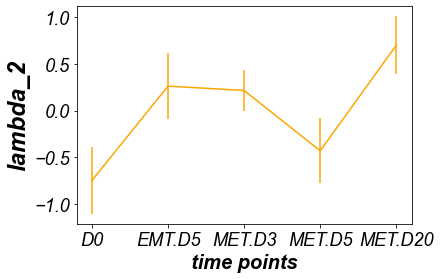

Top upregulated 20 pathways for lambda_3:
['WP_PKCGAMMA_CALCIUM_SIGNALING_PATHWAY_IN_ATAXIA', 'WP_MAP3K1_ROLE_IN_PROMOTING_AND_BLOCKING_GONADAL_DETERMINATION', 'WP_EDA_SIGNALLING_IN_HAIR_FOLLICLE_DEVELOPMENT', 'WP_HEART_DEVELOPMENT', 'WP_NICOTINE_METABOLISM', 'WP_METABOLISM_OF_ALPHALINOLENIC_ACID', 'WP_SEROTONIN_AND_ANXIETY', 'WP_PLATELETMEDIATED_INTERACTIONS_WITH_VASCULAR_AND_CIRCULATING_CELLS', 'WP_ROBO4_AND_VEGF_SIGNALING_PATHWAYS_CROSSTALK', 'WP_EV_RELEASE_FROM_CARDIAC_CELLS_AND_THEIR_FUNCTIONAL_EFFECTS', 'WP_EFFECTS_OF_NITRIC_OXIDE', 'WP_STEROID_BIOSYNTHESIS', 'WP_THYROXINE_THYROID_HORMONE_PRODUCTION', 'WP_CONTROL_OF_IMMUNE_TOLERANCE_BY_VASOACTIVE_INTESTINAL_PEPTIDE', 'WP_MACROPHAGE_MARKERS', 'WP_MAMMALIAN_DISORDER_OF_SEXUAL_DEVELOPMENT', 'WP_SCFA_AND_SKELETAL_MUSCLE_SUBSTRATE_METABOLISM', 'WP_NUCLEOTIDE_GPCRS', 'WP_GLUCOCORTICOID_AND_MINERALCORTICOID_METABOLISM', 'WP_SOMATIC_SEX_DETERMINATION']
Top downregulated 20 pathways for lambda_3:
['WP_AFLATOXIN_B1_METABOLISM', 'WP_BENZOAP

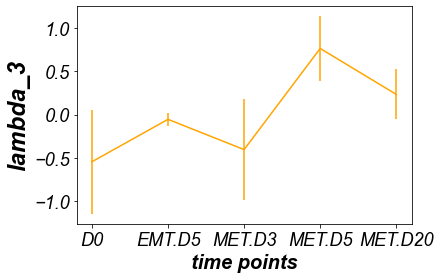

In [13]:
pathway_expression_mat,pathway_list = make_matrix_from_dict(pathway_expression_dict)

####Their surprisal code


pathway_expression_mat = np.power(pathway_expression_mat,2)
lamb = {0:[],1:[],2:[],3:[]}
G = {0:[],1:[],2:[],3:[]}
rep_num = 0
with open(path_to_replicates) as f:
    for line in f:
        rep_num+=1
        a = line[:-1].split("\t")
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change matrix here 
        cols = get_cols(pathway_expression_mat,a)
        Y = make_matrix(cols)
        w, lambda_arrays, G_array = surprisal_analysis(Y)
        print(len(G_array))
        #consistency_check(G_array)
        lamb[0].append(lambda_arrays[0])
        lamb[1].append(lambda_arrays[1])
        lamb[2].append(lambda_arrays[2])
        lamb[3].append(lambda_arrays[3])
        G[0].append(G_array[0])
        G[1].append(G_array[1])
        G[2].append(G_array[2])
        G[3].append(G_array[3])
        
x = list(dict.fromkeys(time_series)) ## Remove duplicates from time_series
x = list(map(float,x))
 
def top_up_20_pathway_names(phenotype,rep_num):   
    top_up_20=[]
    top_up_20_idx = np.argsort(G[phenotype][rep_num])[-20:]
    top_up_20_values = [G[phenotype][rep_num][i] for i in top_up_20_idx]
    for i in top_up_20_idx:
        top_up_20.append(read_pathway_name(path_to_pathway_list,i))
    return top_up_20

def top_down_20_pathway_names(phenotype,rep_num): 
    top_down_20=[]
    top_down_20_idx = np.argsort(G[phenotype][rep_num])[0:20]
    top_down_20_values = [G[phenotype][rep_num][i] for i in top_down_20_idx]
    for i in top_down_20_idx:
        top_down_20.append(read_pathway_name(path_to_pathway_list,i))
    return top_down_20

total_replicates = 3
top_up_20_pathways={0:{0:[],1:[],2:[]},1:{0:[],1:[],2:[]},2:{0:[],1:[],2:[]},3:{0:[],1:[],2:[]}}
top_down_20_pathways={0:{0:[],1:[],2:[]},1:{0:[],1:[],2:[]},2:{0:[],1:[],2:[]},3:{0:[],1:[],2:[]}}
for phenotype in range(4):
    lamb[phenotype] = correct_evectors_sign(lamb[phenotype])
    G[phenotype] = correct_evectors_sign(G[phenotype])
    for rep_num in range(total_replicates):
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change name here
        #with open("./replicates/tfs_replicate_"+str(rep_num)+"_phenotype_"+str(phenotype)+".txt","w") as f1:
            for idx,g in enumerate(G[phenotype][rep_num]):
                # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change gene list here
                s = str(idx)+"\t"+str(genelisttfs[idx])+"\t"+str(g)
                free_energy_array = lamb[phenotype][rep_num]*G[phenotype][rep_num][idx]
                for timept in free_energy_array:
                    s+="\t"+str(timept)
                #f1.write(s+"\n")
            top_up_20_pathways[phenotype][rep_num] = top_up_20_pathway_names(phenotype,rep_num)
            top_down_20_pathways[phenotype][rep_num] = top_down_20_pathway_names(phenotype,rep_num)
    print("Top upregulated 20 pathways for lambda_"+str(phenotype)+":")
    print(top_up_20_pathways[phenotype][0])
    print("Top downregulated 20 pathways for lambda_"+str(phenotype)+":")
    print(top_down_20_pathways[phenotype][0])
    plot_errorbar_plots(x,correct_evectors_sign(lamb[phenotype]),"lambda_"+str(phenotype),"time points")


In [14]:
from math import*
 
def jaccard_similarity(x,y,z):
 
 intersection_cardinality = len(set.intersection(*[set(x), set(y), set(z)]))
 union_cardinality = len(set.union(*[set(x), set(y), set(z)]))
 return intersection_cardinality/float(union_cardinality)

for i in range(0,4):
    print("Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_"+str(i))
    print (jaccard_similarity(top_up_20_pathways[i][0],top_up_20_pathways[i][1],top_up_20_pathways[i][2]))
    print("Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_"+str(i))
    print (jaccard_similarity(top_down_20_pathways[i][0],top_down_20_pathways[i][1],top_down_20_pathways[i][2]))

Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_0
0.6956521739130435
Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_0
0.8571428571428571
Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_1
0.19444444444444445
Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_1
0.2222222222222222
Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_2
0.0
Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_2
0.0
Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_3
0.0
Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_3
0.0
